In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Data Description
- application_{train|test}.csv

    - This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
    - Static data for all applications. One row represents one loan in our data sample.

- bureau.csv
    - All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
    - For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

- bureau_balance.csv
    - Monthly balances of previous credits in Credit Bureau.
    - This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

- POS_CASH_balance.csv
    - Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
    - This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

- credit_card_balance.csv
    - Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
    - This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

- previous_application.csv
    - All previous applications for Home Credit loans of clients who have loans in our sample.
    - There is one row for each previous application related to loans in our data sample.

- installments_payments.csv
    - Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
    - There is a) one row for every payment that was made plus b) one row each for missed payment.
    - One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

- HomeCredit_columns_description.csv
    - This file contains descriptions for the columns in the various data files.
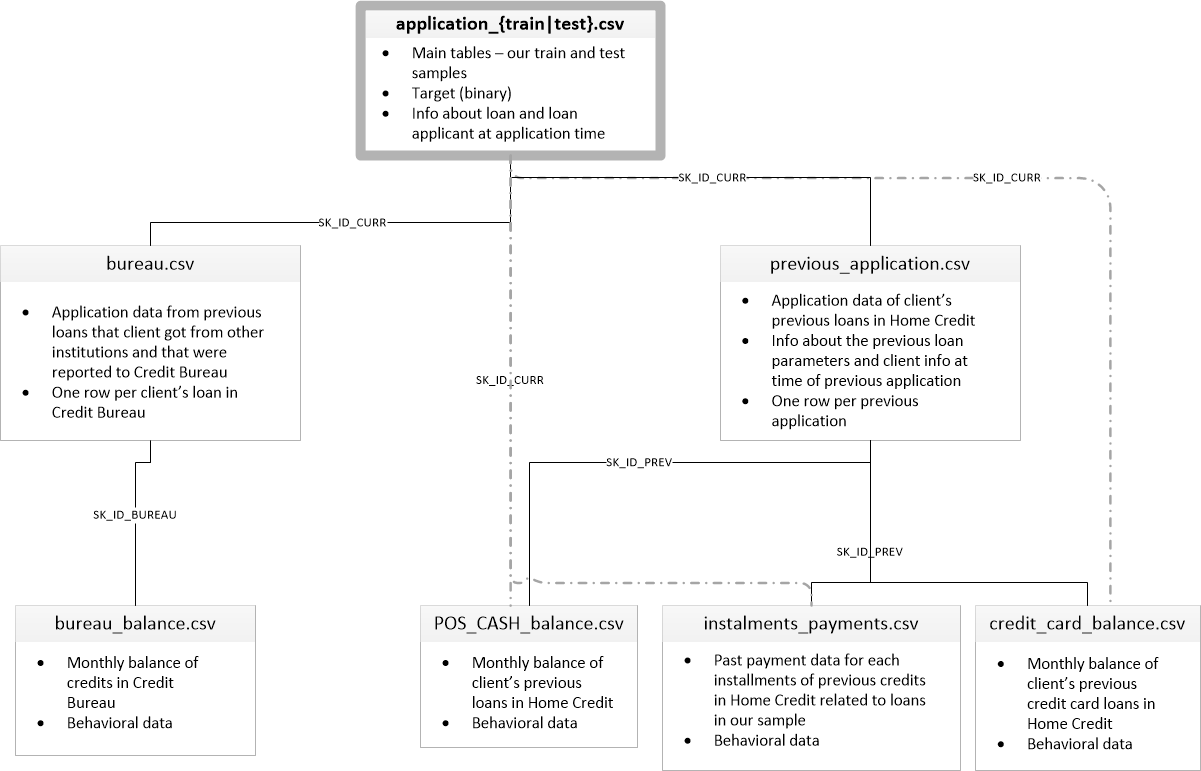

In [70]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

DATA_ROOT_PATH = 'data'

import os
for dirname, _, filenames in os.walk(DATA_ROOT_PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data\application_test.csv
data\application_train.csv
data\bureau.csv
data\bureau_balance.csv
data\credit_card_balance.csv
data\home-credit-default-risk.zip
data\HomeCredit_columns_description.csv
data\installments_payments.csv
data\POS_CASH_balance.csv
data\previous_application.csv
data\sample_submission.csv


In [176]:
########################### Helpers
#################################################################################
## Imports needed for helpers
from scipy import stats
import matplotlib.pyplot as plt # plotting
%matplotlib inline
import seaborn as sns

## -------------------
## Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
## ------------------- 

## -------------------
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
## -------------------

## -------------------
## Table resumer
# :df pandas dataframe to resume                  # type: pd.DataFrame()
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary['Missing'] = df.isnull().sum().values
    summary['Missing %'] = summary['Missing'] / df.shape[0]
    summary['Uniques'] = df.nunique().values
    summary['Uniques %'] = summary['Uniques'] / df.shape[0]
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    
    df_min = pd.DataFrame(df.min(),columns = ['Min Value'])
    df_max = pd.DataFrame(df.max(), columns = ['Max Value'])
    
    summary = summary.join(df_min, how='left')
    summary = summary.join(df_max, how='left')

    summary.reset_index(inplace=True)
    summary.rename(columns={'index':'Name'},inplace=True)
    
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    display(summary)
    
    for col in df.columns:
        print('\n')
        if df[col].dtype == object:
            vc = df[col].value_counts(normalize=True)
            print(col)
            for ix in vc.index:
                print('{}: {}%'.format(ix,round(vc[ix]*100,4)))
        else:
            # Set the width and height of the figure
            plt.figure()
            # Add title
            plt.title(col)
            # Bar chart showing average arrival delay for Spirit Airlines flights by month
            # sns.barplot(x=flight_data.index, y=flight_data['NK'])
            sns.distplot(df[col])
            plt.show()
    
## -------------------

In [167]:
app_test = pd.read_csv(os.path.join(DATA_ROOT_PATH,'application_test.csv')).replace(regex='[^A-Za-z0-9 ]+', value='')
# app_train = pd.read_csv(os.path.join(DATA_ROOT_PATH,'application_train.csv'))
# bureau = pd.read_csv(os.path.join(DATA_ROOT_PATH,'bureau.csv'))
# bureau_bal = pd.read_csv(os.path.join(DATA_ROOT_PATH,'bureau_balance.csv'))
# cc_bal = pd.read_csv(os.path.join(DATA_ROOT_PATH,'credit_card_balance.csv'))
# # home_cred_col_desc = pd.read_csv(os.path.join(DATA_ROOT_PATH,'HomeCredit_columns_description.csv'))
# inst_pymt = pd.read_csv(os.path.join(DATA_ROOT_PATH,'installments_payments.csv'))
# pos_cash_bal = pd.read_csv(os.path.join(DATA_ROOT_PATH,'POS_CASH_balance.csv'))
# prev_app = pd.read_csv(os.path.join(DATA_ROOT_PATH,'previous_application.csv'))
# samp_sub = pd.read_csv(os.path.join(DATA_ROOT_PATH,'sample_submission.csv'))

Dataset Shape: (48744, 121)


,Name,dtypes,Missing,Missing %,Uniques,Uniques %,First Value,Second Value,Min Value,Max Value,Entropy
0,SK_ID_CURR,int64,0,0.000000,48744,1.000000,100001,100005,100001,456250,15.57
1,NAME_CONTRACT_TYPE,object,0,0.000000,2,0.000041,Cash loans,Cash loans,Cash loans,Revolving loans,0.07
2,CODE_GENDER,object,0,0.000000,2,0.000041,F,M,F,M,0.91
3,FLAG_OWN_CAR,object,0,0.000000,2,0.000041,N,N,N,Y,0.92
4,FLAG_OWN_REALTY,object,0,0.000000,2,0.000041,Y,Y,N,Y,0.89
5,CNT_CHILDREN,int64,0,0.000000,11,0.000226,0,0,0,20,1.19
6,AMT_INCOME_TOTAL,float64,0,0.000000,606,0.012432,135000,99000,26941.5,4.41e+06,5.01
7,AMT_CREDIT,float64,0,0.000000,2937,0.060254,568800,222768,45000,2.2455e+06,8.91
8,AMT_ANNUITY,float64,24,0.000492,7491,0.153680,20560.5,17370,2295,180576,11.55
9,AMT_GOODS_PRICE,float64,0,0.000000,677,0.013889,450000,180000,45000,2.2455e+06,6.20


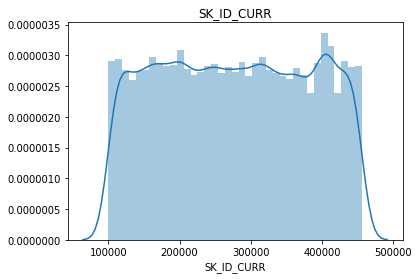



NAME_CONTRACT_TYPE
Cash loans: 99.0994%
Revolving loans: 0.9006%


CODE_GENDER
F: 67.04%
M: 32.96%


FLAG_OWN_CAR
N: 66.2871%
Y: 33.7129%


FLAG_OWN_REALTY
Y: 69.0505%
N: 30.9495%




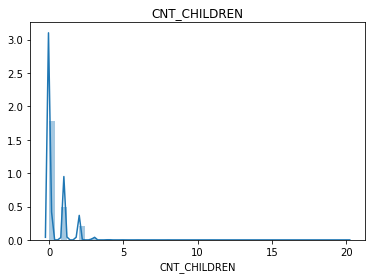

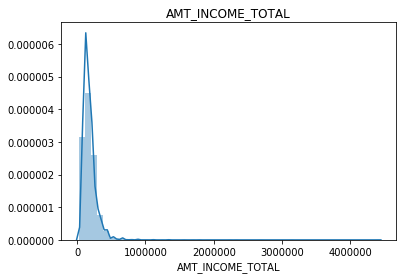

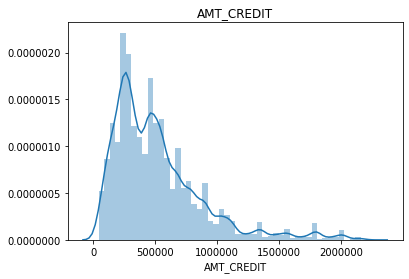

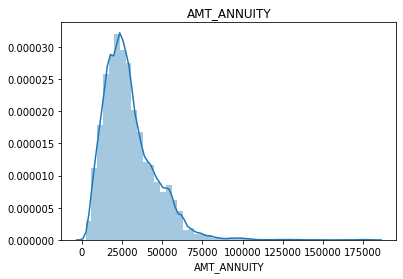

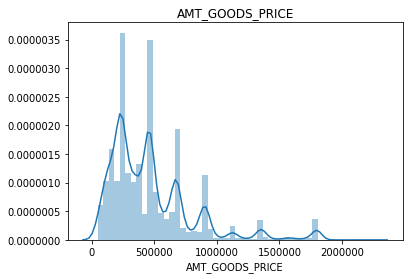



NAME_TYPE_SUITE
Unaccompanied: 83.0535%
Family: 12.2949%
Spouse partner: 3.0272%
Children: 0.853%
OtherB: 0.4411%
OtherA: 0.2279%
Group of people: 0.1024%


NAME_INCOME_TYPE
Working: 50.3303%
Commercial associate: 23.3916%
Pensioner: 19.0239%
State servant: 7.246%
Student: 0.0041%
Unemployed: 0.0021%
Businessman: 0.0021%


NAME_EDUCATION_TYPE
Secondary  secondary special: 69.7276%
Higher education: 25.677%
Incomplete higher: 3.5368%
Lower secondary: 0.9745%
Academic degree: 0.0841%


NAME_FAMILY_STATUS
Married: 66.2297%
Single  not married: 14.4346%
Civil marriage: 8.7416%
Separated: 6.0623%
Widow: 4.5318%


NAME_HOUSING_TYPE
House  apartment: 89.5392%
With parents: 4.5831%
Municipal apartment: 3.3173%
Rented apartment: 1.473%
Office apartment: 0.835%
Coop apartment: 0.2523%




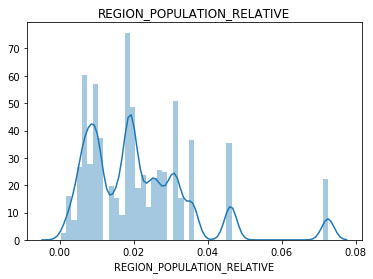

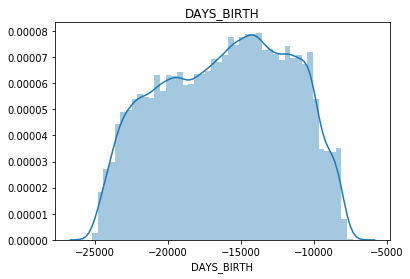

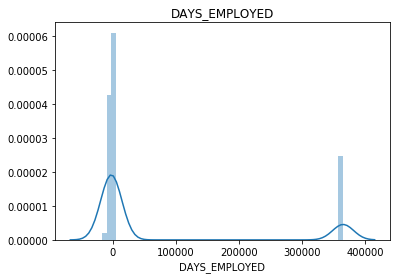

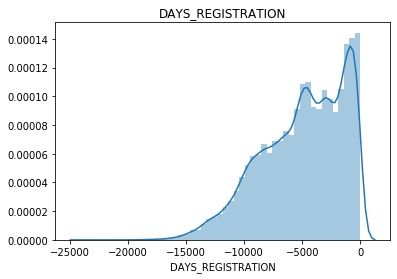

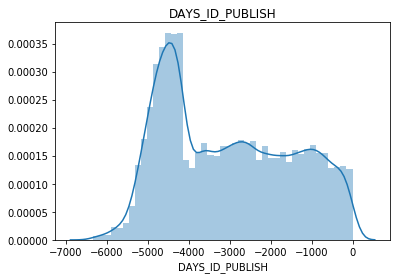

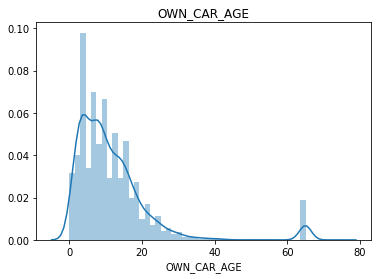

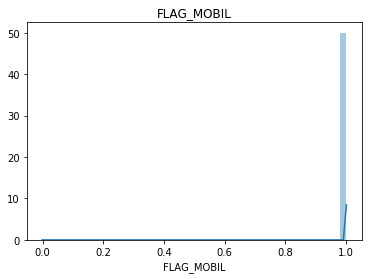

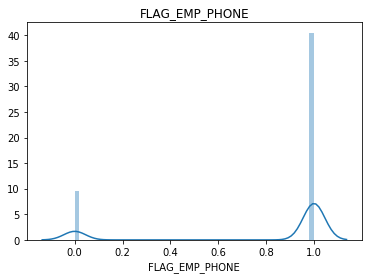

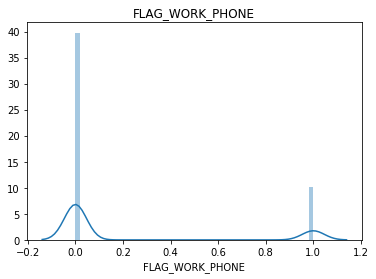

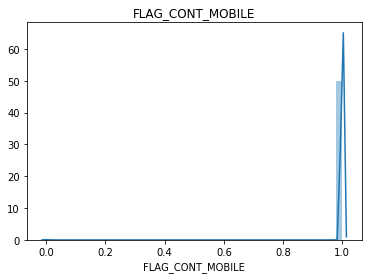

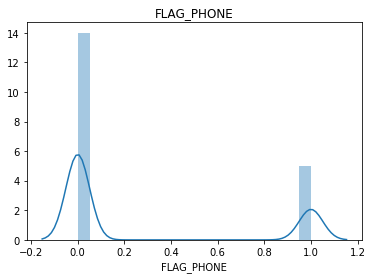

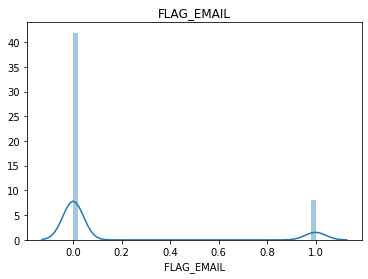



OCCUPATION_TYPE
Laborers: 26.1173%
Sales staff: 15.3052%
Core staff: 13.1597%
Managers: 10.7849%
Drivers: 8.3678%
High skill tech staff: 5.5946%
Accountants: 4.9126%
Medicine staff: 3.9712%
Security staff: 2.7611%
Cooking staff: 2.6977%
Cleaning staff: 1.9795%
Private service staff: 1.373%
Lowskill Laborers: 0.8208%
Secretaries: 0.6427%
Waitersbarmen staff: 0.5371%
Realty agents: 0.4164%
HR staff: 0.3138%
IT staff: 0.2444%




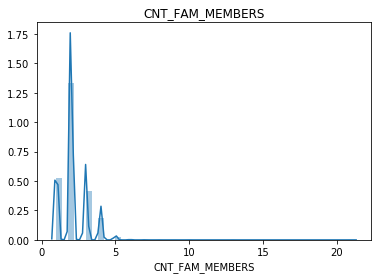

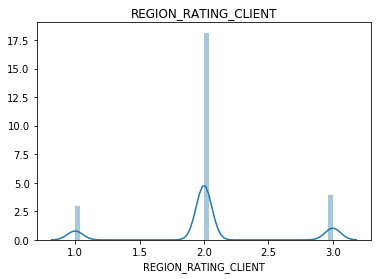

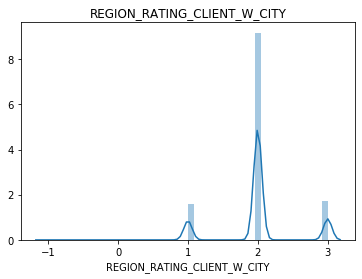



WEEKDAY_APPR_PROCESS_START
TUESDAY: 20.0045%
WEDNESDAY: 17.3498%
THURSDAY: 17.2698%
MONDAY: 17.2452%
FRIDAY: 14.8736%
SATURDAY: 9.4432%
SUNDAY: 3.8138%




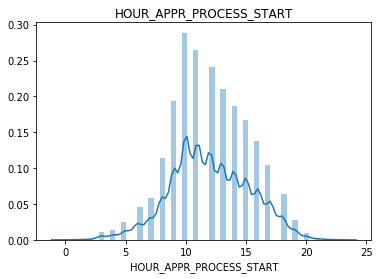

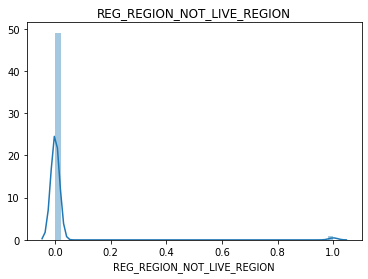

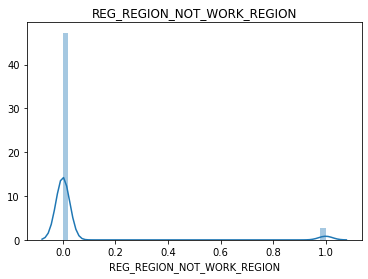

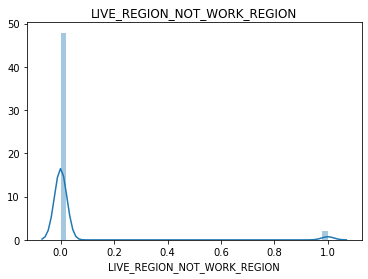

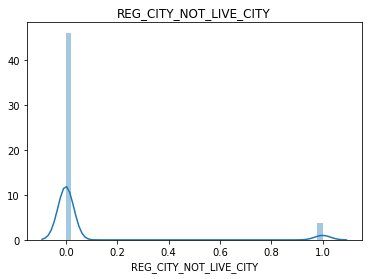

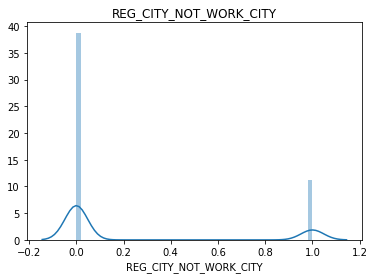

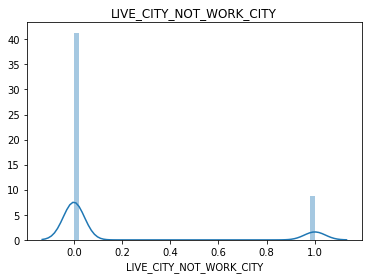



ORGANIZATION_TYPE
Business Entity Type 3: 22.2386%
XNA: 19.0259%
Selfemployed: 12.1451%
Other: 5.5535%
Medicine: 3.5204%
Government: 3.0937%
Business Entity Type 2: 3.0342%
Trade type 7: 2.6731%
School: 2.6403%
Construction: 2.1315%
Kindergarten: 2.1295%
Business Entity Type 1: 1.8197%
Transport type 4: 1.8136%
Trade type 3: 1.1858%
Military: 1.0873%
Industry type 9: 1.0237%
Industry type 3: 1.0032%
Security: 0.9683%
Transport type 2: 0.9191%
Police: 0.9047%
Housing: 0.8924%
Industry type 11: 0.8534%
Bank: 0.7673%
Security Ministries: 0.6996%
Services: 0.6196%
Postal: 0.6032%
Agriculture: 0.599%
Restaurant: 0.5826%
Trade type 2: 0.4965%
University: 0.4534%
Industry type 7: 0.4452%
Industry type 1: 0.3652%
Transport type 3: 0.357%
Industry type 4: 0.3426%
Electricity: 0.32%
Hotel: 0.2749%
Trade type 6: 0.2503%
Industry type 5: 0.199%
Telecom: 0.1949%
Emergency: 0.1867%
Insurance: 0.1641%
Industry type 2: 0.158%
Industry type 12: 0.158%
Realtor: 0.1477%
Advertising: 0.1457%
Trade type 

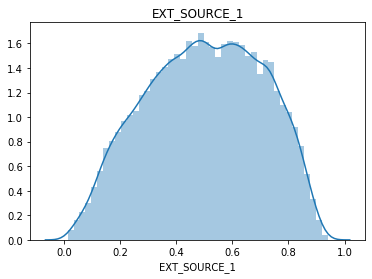

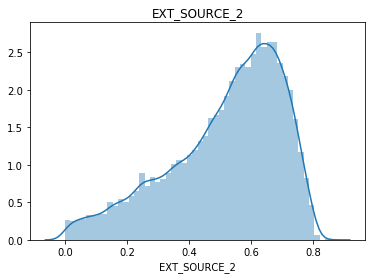

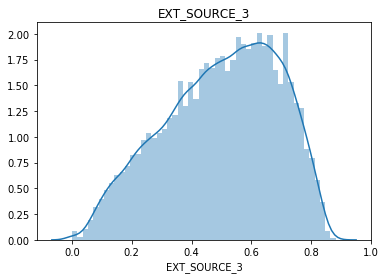

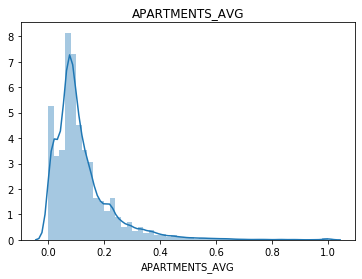

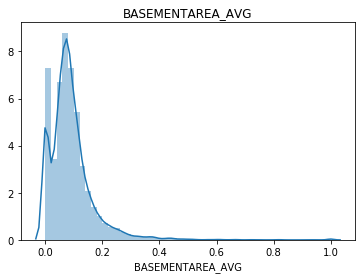

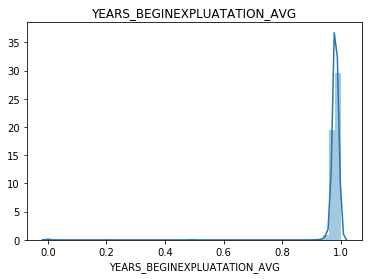

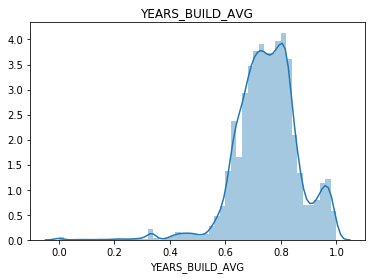

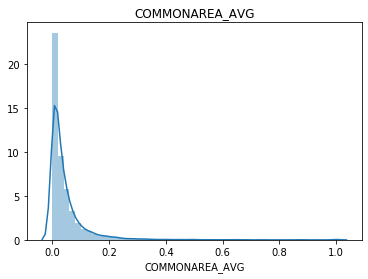

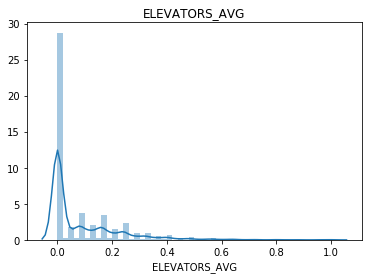

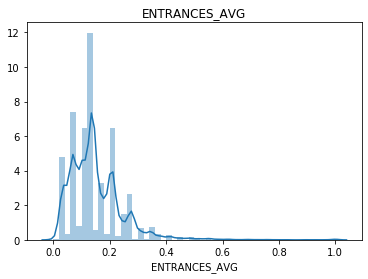

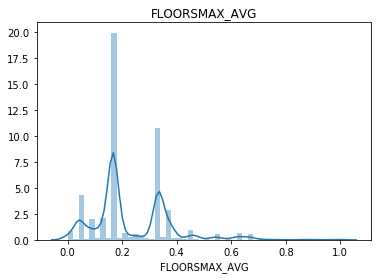

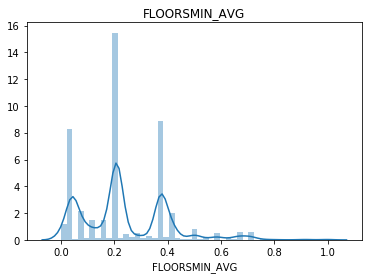

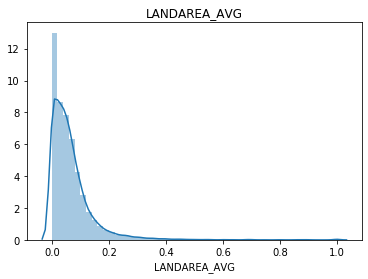

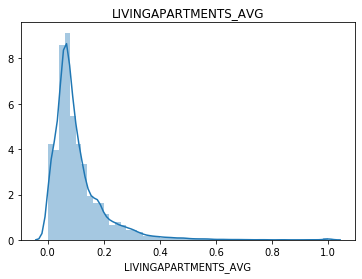

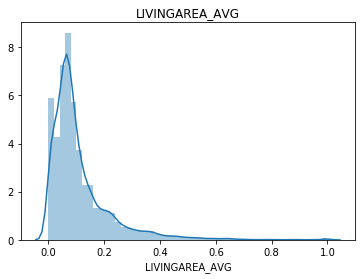

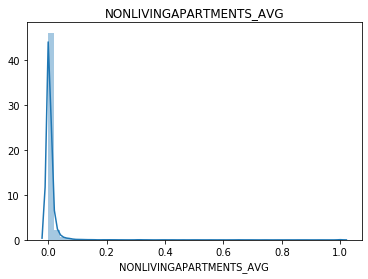

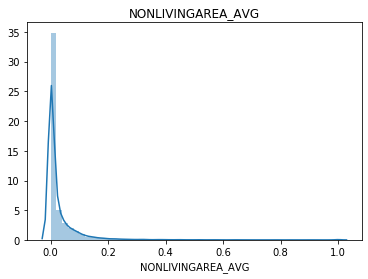

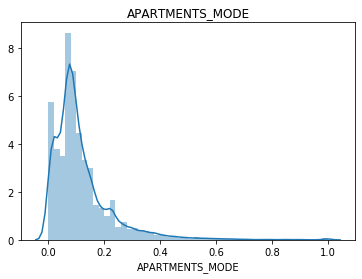

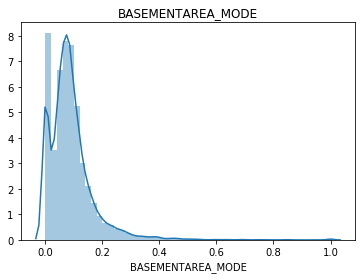

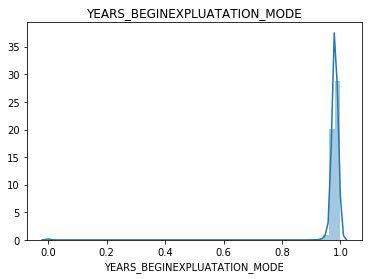

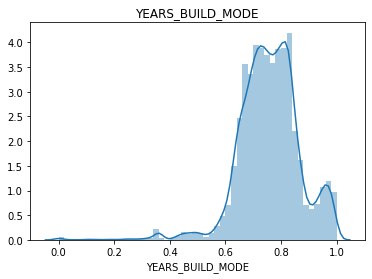

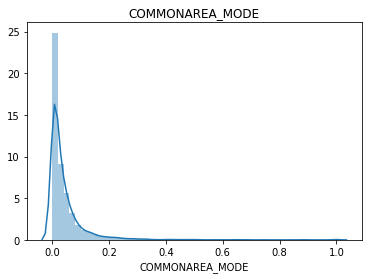

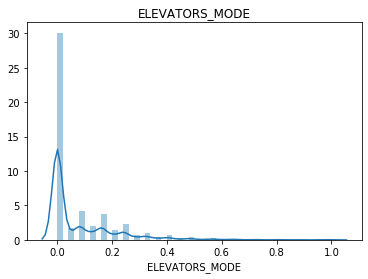

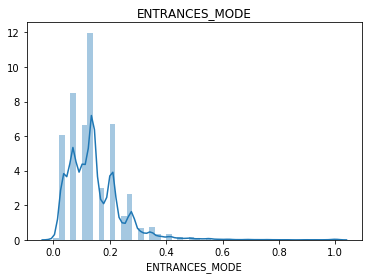

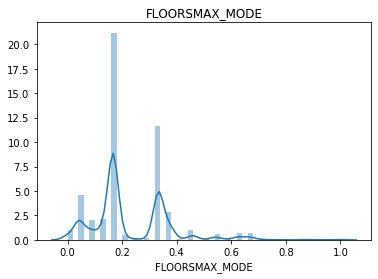

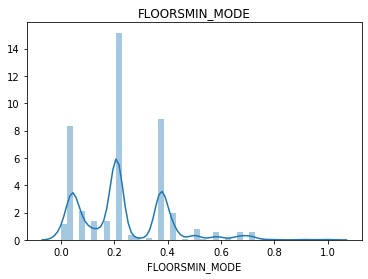

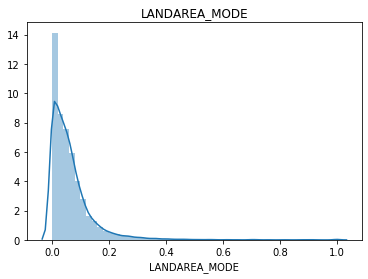

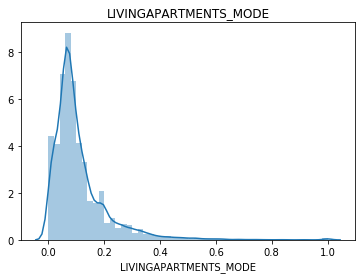

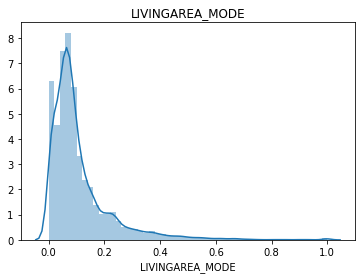

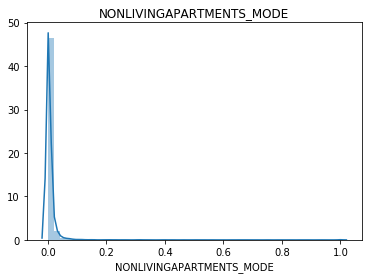

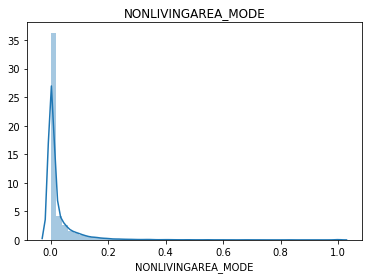

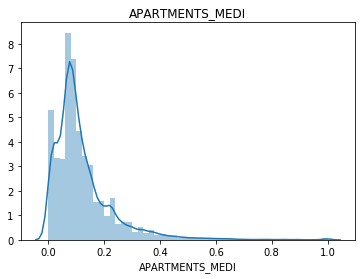

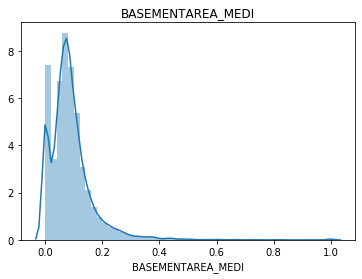

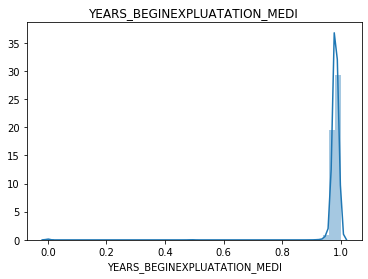

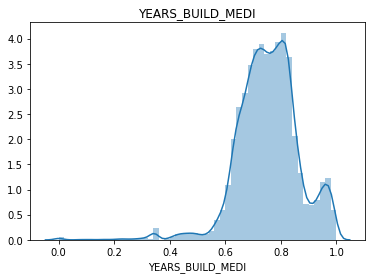

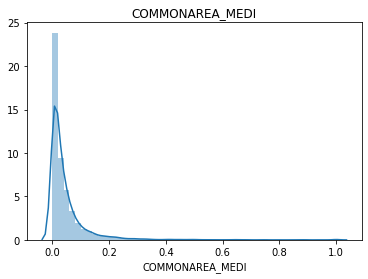

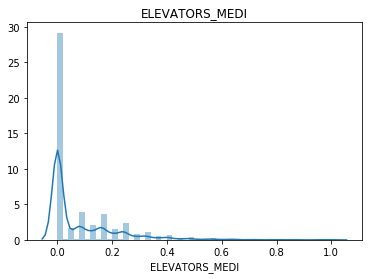

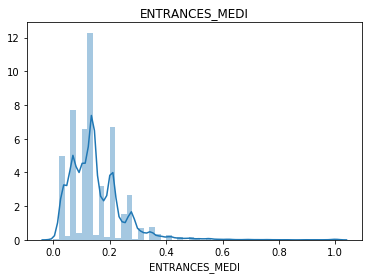

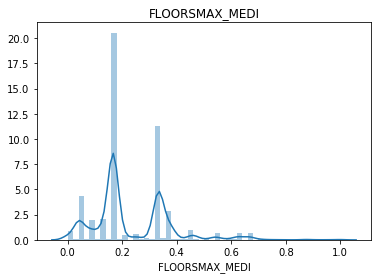

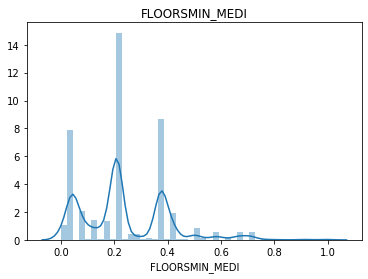

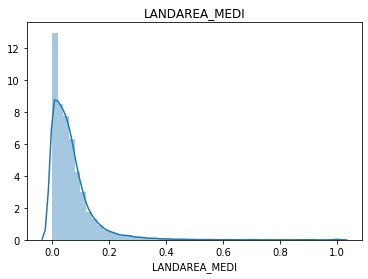

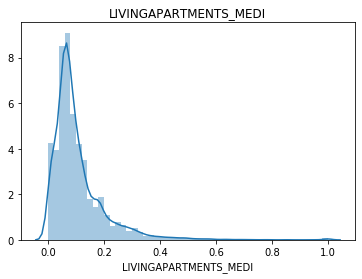

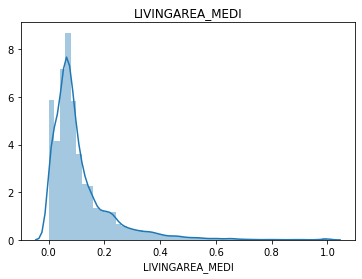

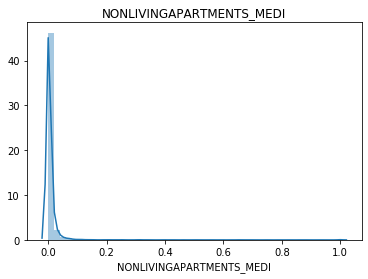

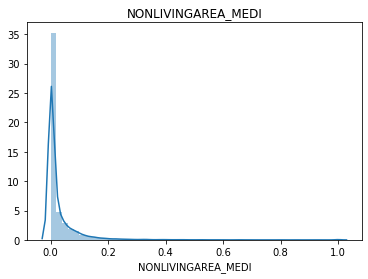



FONDKAPREMONT_MODE
reg oper account: 76.0268%
reg oper spec account: 12.4788%
org spec account: 5.7691%
not specified: 5.7252%


HOUSETYPE_MODE
block of flats: 98.1453%
specific housing: 1.0428%
terraced house: 0.8119%




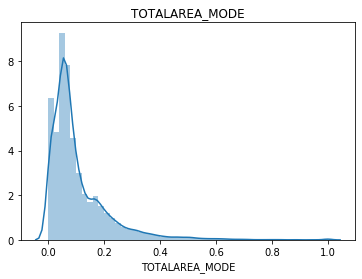



WALLSMATERIAL_MODE
Panel: 45.3463%
Stone brick: 41.9862%
Block: 5.7462%
Wooden: 3.195%
Mixed: 1.4205%
Monolithic: 1.1629%
Others: 1.1428%


EMERGENCYSTATE_MODE
No: 98.6584%
Yes: 1.3416%




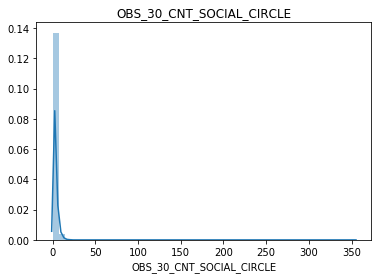

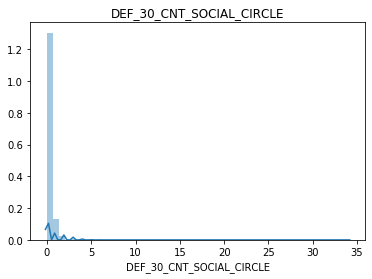

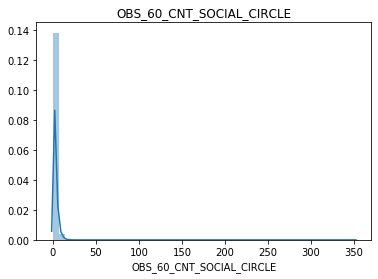

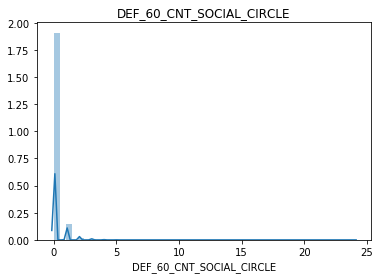

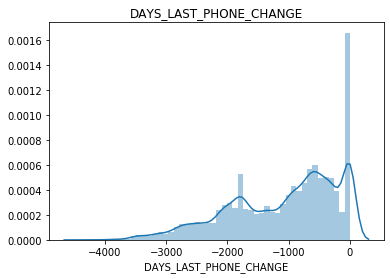

D:\Users\Franco\anaconda3\envs\risk_default\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


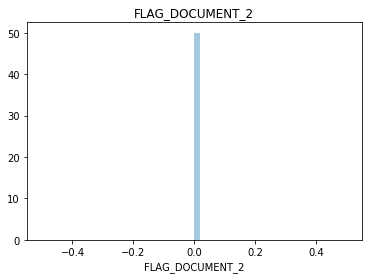

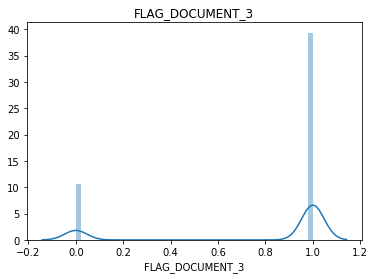

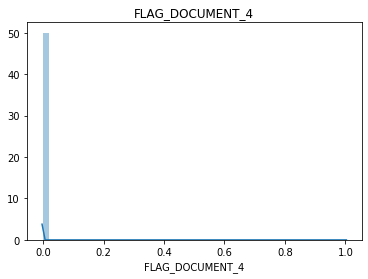

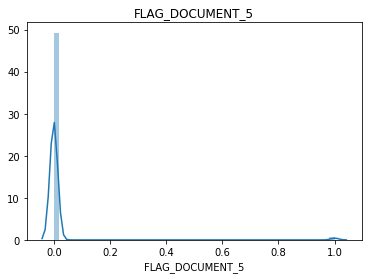

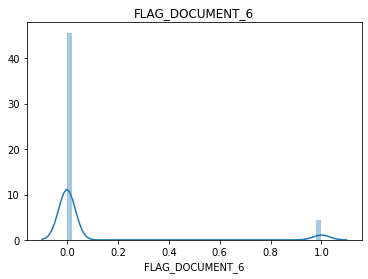

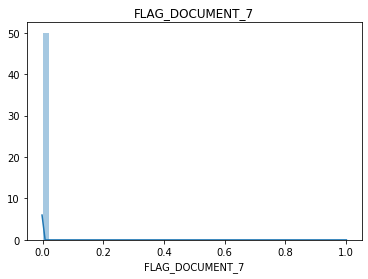

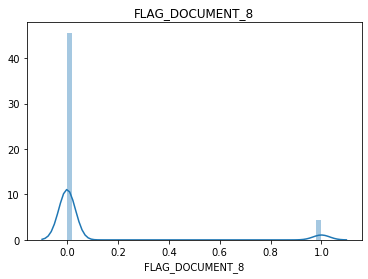

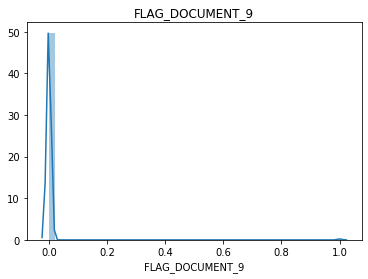

D:\Users\Franco\anaconda3\envs\risk_default\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


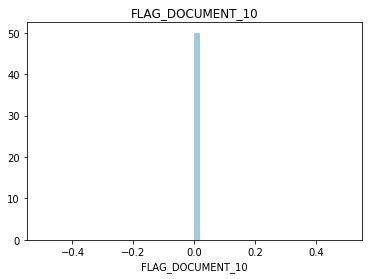

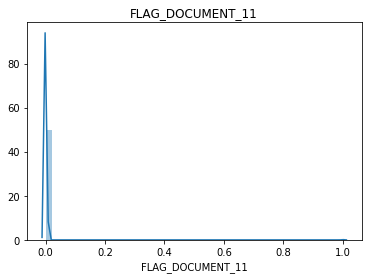

D:\Users\Franco\anaconda3\envs\risk_default\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


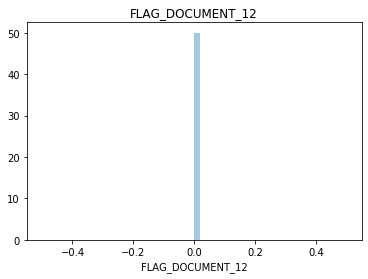

D:\Users\Franco\anaconda3\envs\risk_default\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


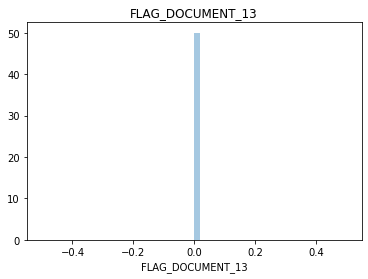

D:\Users\Franco\anaconda3\envs\risk_default\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


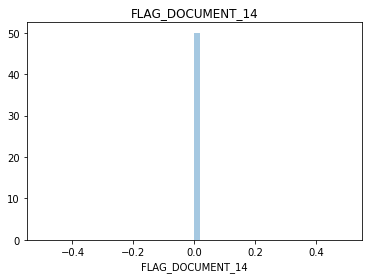

D:\Users\Franco\anaconda3\envs\risk_default\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


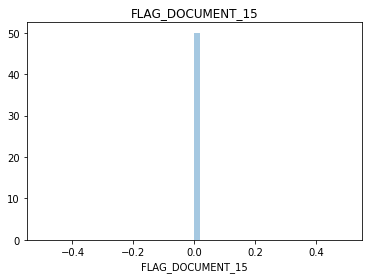

D:\Users\Franco\anaconda3\envs\risk_default\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


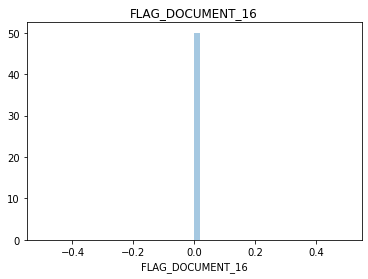

D:\Users\Franco\anaconda3\envs\risk_default\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


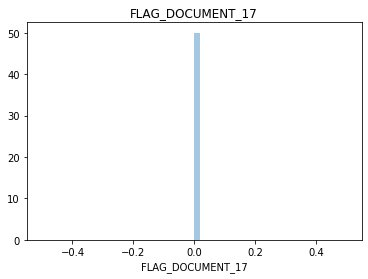

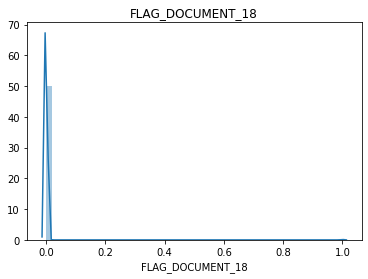

D:\Users\Franco\anaconda3\envs\risk_default\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


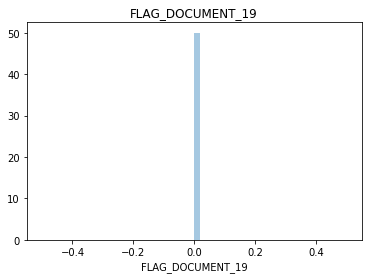

D:\Users\Franco\anaconda3\envs\risk_default\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


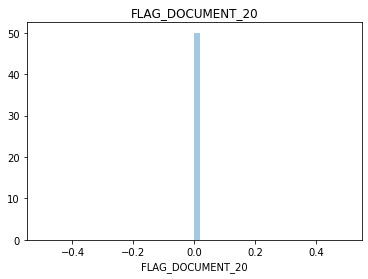

D:\Users\Franco\anaconda3\envs\risk_default\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


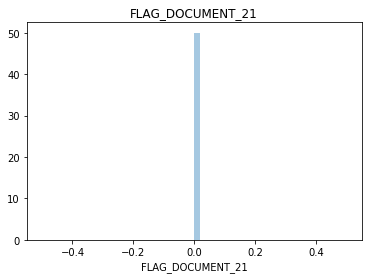

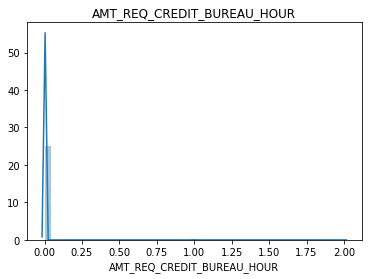

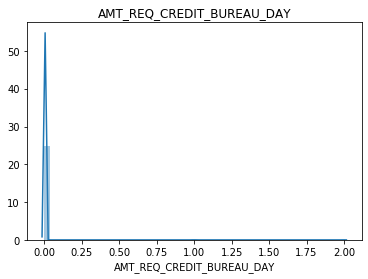

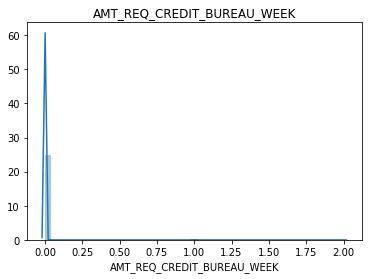

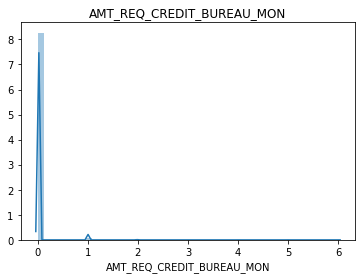

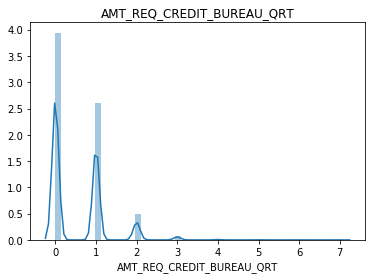

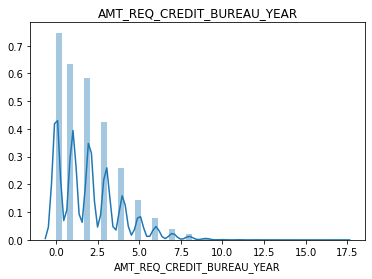

In [177]:
resumetable(app_test)